In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def read_gtfs_files():
    """
    Reads necessary GTFS static files and returns them as DataFrames.
    """
    routes_df = pd.read_csv('GTFS-Static-Data/routes.txt')
    trips_df = pd.read_csv('GTFS-Static-Data/trips.txt')
    stops_df = pd.read_csv('GTFS-Static-Data/stops.txt')
    stop_times_df = pd.read_csv('GTFS-Static-Data/stop_times.txt')
    calendar_df = pd.read_csv('GTFS-Static-Data/calendar.txt')
    return routes_df, trips_df, stops_df, stop_times_df, calendar_df

In [3]:
def filter_by_route(routes_df, route_short_name):
    """
    Filters routes by short name and returns the route ID.
    """
    bus_route_id = routes_df[routes_df['route_short_name'] == route_short_name]['route_id'].iloc[0]
    return bus_route_id

In [4]:
def filter_by_stop(stops_df, stop_name):
    sfu_stop_id = stops_df[stops_df['stop_name'].str.contains(stop_name, case=False, na=False)]['stop_id'].iloc[0]
    return sfu_stop_id

In [5]:
def filter_trips_to_SFU_by_route(trips_df, route_id, direction_id):
    """
    Filters trips by route ID.
    direction_id = 0 -> Production Way to SFU, direction_id = 1 -> SFU to Production Way
    """
    return trips_df[(trips_df['route_id'] == route_id) &
                   (direction_id == direction_id)]

In [6]:
def filter_stop_times_by_trip_and_stop(stop_times_df, trip_to_SFU_df, stop_id):
    """
    Filters stop times by trip ID and stop ID.
    """
    merged_df = pd.merge(stop_times_df, trip_to_SFU_df, on='trip_id')
    filtered_df = merged_df[merged_df['stop_id']==stop_id]
    return filtered_df

In [7]:
def get_trips_by_day(df,calendar_df, day_name):
    """
    Filter trips by day.
    
    :param df: DataFrame containing the trip data
    :param day_name: Name of the day to filter by (e.g., 'Monday')
    :return: DataFrame with trips that run on the specified day
    """
    trip_at_SFU_service = pd.merge(df, calendar_df, on='service_id')
    filtered_trip = trip_at_SFU_service[trip_at_SFU_service[day_name]==1]
    selected_columns = ['trip_id', 'arrival_time', day_name]
    filtered_trip = filtered_trip[selected_columns]
    filtered_trip= filtered_trip.sort_values(by='arrival_time')
    filtered_trip = filtered_trip.reset_index(drop=True)
    return filtered_trip

In [8]:
def convert_time(time_str):
        """Converts time strings into timedelta, adjusting for times beyond 24:00:00."""
        hours, minutes, seconds = map(int, time_str.split(':'))
        if hours >= 24:
            hours -= 24  # Adjust hours to 0-23 range
            # Add one day to the timedelta for times past 24:00:00
            return pd.Timedelta(days=1) + pd.Timedelta(hours=hours, minutes=minutes, seconds=seconds)
        else:
            return pd.Timedelta(hours=hours, minutes=minutes, seconds=seconds)

In [9]:
def calculate_time_diff_and_period(df):
    """
    Calculates time differences between consecutive buses and assigns period based on arrival time.
    This function is a placeholder to illustrate where you'd calculate 'Time Diff' and 'Period'.
    """
    df['timedelta'] = df['arrival_time'].apply(convert_time)

    # Calculate the time difference in minutes
    df['time_diff'] = df['timedelta'].diff().dt.total_seconds() / 60
    df['time_diff'].fillna(0, inplace=True) 
    
    # Remove the 'timedelta' column it's no longer needed
    df.drop('timedelta', axis=1, inplace=True)
    
    return df

In [10]:
def convert_time_cluster(time_str):
    # Split the time string into components
    hours, minutes, seconds = map(int, time_str.split(':'))
    # Adjust hours if they exceed 24 and calculate total minutes past midnight
    total_minutes = ((hours - 24) * 60 if hours >= 24 else hours * 60) + minutes + seconds / 60
    return total_minutes

In [11]:
def applying_clustering(df,bus_and_day):
#     columns_need = ['trip_id','arrival_time','time_diff']
#     df = df[columns_need]
    df['minutes_past_midnight'] = df['arrival_time'].apply(convert_time_cluster)
#     print(df)
    X = df[['minutes_past_midnight', 'time_diff']]

#     kmeans = KMeans(n_clusters=5,n_init=10, random_state=42)
    kmeans = KMeans(n_clusters=3,n_init=10, random_state=42)
    kmeans.fit(X)

    # Assign clusters back to the DataFrame
    df['cluster'] = kmeans.labels_
    df = df[['trip_id','arrival_time','time_diff','cluster','minutes_past_midnight']]
    
#     df.to_csv(bus_and_day+ "_clustering.csv",index=True)
    
    # Set the style of the visualization
    sns.set(style="whitegrid")

    # Plot
    plt.figure(figsize=(12, 6))

    # Scatter plot for minutes past midnight vs time_diff colored by cluster
    sns.scatterplot(data=df, x='minutes_past_midnight', y='time_diff', hue='cluster', palette='viridis', alpha=0.7, s=100)

    # Enhance plot
#     plt.title(bus_and_day + ' Cluster Distribution by Minutes Past Midnight and Time Difference')
#     plt.xlabel('Minutes Past Midnight')
#     plt.ylabel('Time Difference (minutes)')
#     plt.legend(title='Cluster')
#     # Save the plot to a file
#     plt.savefig(bus_and_day+'_ScheduleCluster.png', dpi=300, bbox_inches='tight')

In [26]:
def main():
    routes_df, trips_df, stops_df, stop_times_df, calendar_df = read_gtfs_files()
    
    # get bus route_id and stop sfu transit bay 2
    route_145_id = filter_by_route(routes_df, '145')
    route_144_id = filter_by_route(routes_df, '144')
    route_143_id = filter_by_route(routes_df, '143')
    route_R5_id = filter_by_route(routes_df, 'R5')
    print(route_143_id)
    sfu_stop_id = filter_by_stop(stops_df,'SFU Transportation Centre @ Bay 2')
    print(sfu_stop_id)
#     trips_to_SFU_145 = filter_trips_to_SFU_by_route(trips_df,  route_145_id, 0)
#     trips_to_SFU_arrival_time_145 = filter_stop_times_by_trip_and_stop(stop_times_df, trips_to_SFU_145, sfu_stop_id)
    
#     trips_to_SFU_144 = filter_trips_to_SFU_by_route(trips_df, route_144_id, 0)
#     trips_to_SFU_arrival_time_144 = filter_stop_times_by_trip_and_stop(stop_times_df, trips_to_SFU_144, sfu_stop_id)
    
    trips_to_SFU_143 = filter_trips_to_SFU_by_route(trips_df, route_143_id, 0)
#     print(trips_to_SFU_143)
    trips_to_SFU_arrival_time_143 = filter_stop_times_by_trip_and_stop(stop_times_df, trips_to_SFU_143, sfu_stop_id)
    print(trips_to_SFU_arrival_time_143)
    
#     trips_to_SFU_R5 = filter_trips_to_SFU_by_route(trips_df, route_R5_id, 0)
#     trips_to_SFU_arrival_time_R5 = filter_stop_times_by_trip_and_stop(stop_times_df, trips_to_SFU_R5, sfu_stop_id)
    
    week_day = 'monday'
#     trips_to_SFU_arrival_time_weekday_145 = get_trips_by_day(trips_to_SFU_arrival_time_145,calendar_df, week_day)
#     trips_to_SFU_arrival_time_weekday_145 = calculate_time_diff_and_period(trips_to_SFU_arrival_time_weekday_145)
#     applying_clustering(trips_to_SFU_arrival_time_weekday_145, 'bus_145_weekday')
#     trips_to_SFU_arrival_time_weekday_145.to_csv('bus_145_weekday_trips.csv',index=True)
    
#     trips_to_SFU_arrival_time_weekday_144 = get_trips_by_day(trips_to_SFU_arrival_time_144,calendar_df, week_day)
#     trips_to_SFU_arrival_time_weekday_144 = calculate_time_diff_and_period(trips_to_SFU_arrival_time_weekday_144)
#     applying_clustering(trips_to_SFU_arrival_time_weekday_144, 'bus_144_weekday')
#     trips_to_SFU_arrival_time_weekday_144.to_csv('bus_144_weekday_trips.csv',index=True)
    
    trips_to_SFU_arrival_time_weekday_143 = get_trips_by_day(trips_to_SFU_arrival_time_143,calendar_df, week_day)
#     print(trips_to_SFU_arrival_time_weekday_143)
    trips_to_SFU_arrival_time_weekday_143 = calculate_time_diff_and_period(trips_to_SFU_arrival_time_weekday_143)
    applying_clustering(trips_to_SFU_arrival_time_weekday_143, 'bus_143_weekday')
#     print(trips_to_SFU_arrival_time_weekday_143)
#     trips_to_SFU_arrival_time_weekday_143.to_csv('bus_143_weekday_trips.csv',index=True)
    
#     trips_to_SFU_arrival_time_weekday_R5 = get_trips_by_day(trips_to_SFU_arrival_time_R5,calendar_df, week_day)
#     trips_to_SFU_arrival_time_weekday_R5 = calculate_time_diff_and_period(trips_to_SFU_arrival_time_weekday_R5)
#     applying_clustering(trips_to_SFU_arrival_time_weekday_R5, 'bus_R5_weekday')
#     trips_to_SFU_arrival_time_weekday_R5.to_csv('bus_R5_weekday_trips.csv',index=True)
    
    sat = 'saturday'
#     trips_to_SFU_arrival_time_sat_145 = get_trips_by_day(trips_to_SFU_arrival_time_145,calendar_df, sat)
#     trips_to_SFU_arrival_time_sat_145 = calculate_time_diff_and_period(trips_to_SFU_arrival_time_sat_145)
#     applying_clustering(trips_to_SFU_arrival_time_sat_145, 'bus_145_saturday')
#     trips_to_SFU_arrival_time_sat_145.to_csv('bus_145_saturday_trips.csv',index=True)

#     trips_to_SFU_arrival_time_sat_144 = get_trips_by_day(trips_to_SFU_arrival_time_144,calendar_df, sat)
#     trips_to_SFU_arrival_time_sat_144 = calculate_time_diff_and_period(trips_to_SFU_arrival_time_sat_144)
#     applying_clustering(trips_to_SFU_arrival_time_sat_144, 'bus_144_saturday')
#     trips_to_SFU_arrival_time_sat_144.to_csv('bus_144_saturday_trips.csv',index=True)

#     trips_to_SFU_arrival_time_sat_R5 = get_trips_by_day(trips_to_SFU_arrival_time_R5,calendar_df, sat)
#     trips_to_SFU_arrival_time_sat_R5 = calculate_time_diff_and_period(trips_to_SFU_arrival_time_sat_R5)
#     applying_clustering(trips_to_SFU_arrival_time_sat_R5, 'bus_R5_saturday')
#     trips_to_SFU_arrival_time_sat_R5.to_csv('bus_R5_saturday_trips.csv',index=True)
    
    sun = 'sunday'
#     trips_to_SFU_arrival_time_sun_145 = get_trips_by_day(trips_to_SFU_arrival_time_145,calendar_df, sun)
#     trips_to_SFU_arrival_time_sun_145 = calculate_time_diff_and_period(trips_to_SFU_arrival_time_sun_145)
#     applying_clustering(trips_to_SFU_arrival_time_sun_145, 'bus_145_sunday')
#     trips_to_SFU_arrival_time_sun_145.to_csv('bus_145_sunday_trips.csv',index=True)

#     trips_to_SFU_arrival_time_sun_144 = get_trips_by_day(trips_to_SFU_arrival_time_144,calendar_df, sun)
#     trips_to_SFU_arrival_time_sun_144 = calculate_time_diff_and_period(trips_to_SFU_arrival_time_sun_144)
#     applying_clustering(trips_to_SFU_arrival_time_sun_144, 'bus_144_sunday')
#     trips_to_SFU_arrival_time_sun_144.to_csv('bus_144_sunday_trips.csv',index=True)

#     trips_to_SFU_arrival_time_sun_R5 = get_trips_by_day(trips_to_SFU_arrival_time_R5,calendar_df, sun)
#     trips_to_SFU_arrival_time_sun_R5 = calculate_time_diff_and_period(trips_to_SFU_arrival_time_sun_R5)
#     applying_clustering(trips_to_SFU_arrival_time_sun_R5, 'bus_R5_sunday')
#     trips_to_SFU_arrival_time_sun_R5.to_csv('bus_R5_sunday_trips.csv',index=True)

6656
1873
      trip_id arrival_time departure_time  stop_id  stop_sequence  \
402  13678134     10:10:07       10:10:07     1873              4   
407  13678135     10:30:07       10:30:07     1873              4   
412  13678136     10:50:07       10:50:07     1873              4   
417  13678137     11:10:07       11:10:07     1873              4   
422  13678138     11:30:07       11:30:07     1873              4   
427  13678139     11:50:07       11:50:07     1873              4   
432  13678140     12:10:07       12:10:07     1873              4   
437  13678141     12:30:07       12:30:07     1873              4   
442  13678142     12:50:07       12:50:07     1873              4   
447  13678143     13:10:07       13:10:07     1873              4   
452  13678144     13:30:07       13:30:07     1873              4   
457  13678145     13:50:07       13:50:07     1873              4   
462  13678146     14:10:07       14:10:07     1873              4   
467  13678147     14:36:

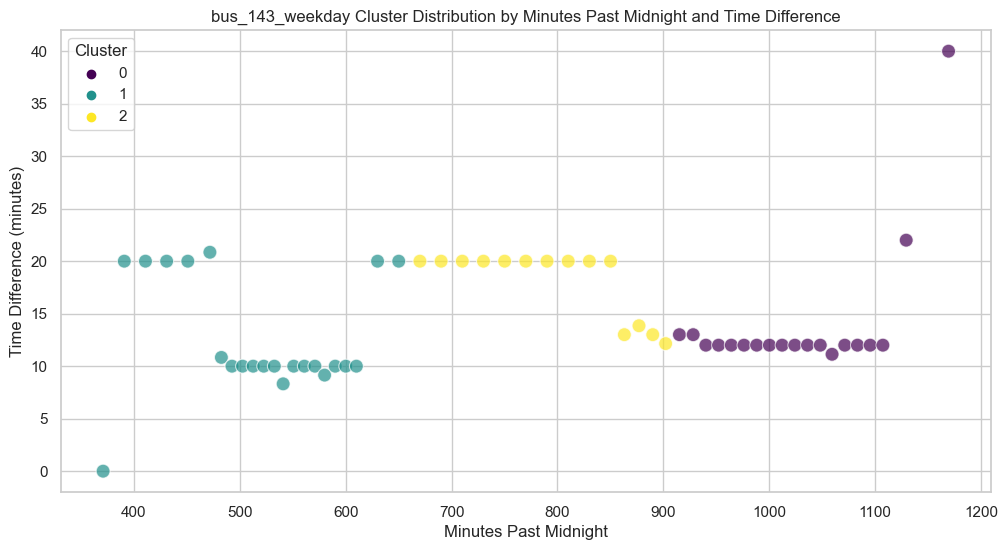

In [27]:
main()